# Scrape and download - Introduction
This notebook uses the official website of Polish Parliment to scrape the information about all current deputies.
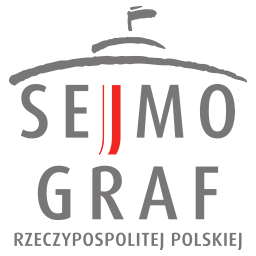


# Environment setup

## Google Drive mount
I'm using Google Colaboratory as my default platform, therefore I need to set up my environment to integrate it with Google Drive. You can skip this bit if you're working locally.

1. Mount Google Drive on the runtime to be able to read and write files. This will ask you to log in to your Google Account and provide an authorization code.
2. Create a symbolic link to a working directory 
3. Change the directory to the one where I cloned my repository.


In [1]:
# mount Google Drive on the runtime
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# create a symbolic link to a working directory
!ln -s /content/gdrive/My\ Drive/Colab\ Notebooks/SEJMograf /mydrive

# navigate to the working directory
%cd /mydrive

ln: failed to create symbolic link '/mydrive/SEJMograf': File exists
/content/gdrive/My Drive/Colab Notebooks/SEJMograf


## Libraries & functions
Let's now install missing libraries and import the necessary libraries and functions we're gonna use in this notebook.

- `requests` - http handling
- `BeautifulSoup` - html parsing & web-scraping
- `urllib.request` - url-opening
- `tqdm.notebook` - loop progress bar for notebooks
- `timeit` - cell runtime check
- `numpy` - linear algebra
- `pandas` - data manipulation & analysis
- `sys` - system-specific parameters & functions
- `os` - operating system interfaces
- `os.path` - pathname manipulation
- `json` - JSON files handling

In [3]:
# install webdriver for chrome and copy to the executables directoryselenium
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
# selenium
!pip install selenium

Reading package lists... Done
Building dependency tree       
Reading state information... Done
chromium-chromedriver is already the newest version (87.0.4280.66-0ubuntu0.18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
cp: '/usr/lib/chromium-browser/chromedriver' and '/usr/bin/chromedriver' are the same file


In [4]:
import requests
import bs4
from bs4 import BeautifulSoup
import tqdm.notebook as tq
import timeit
import numpy as np
import pandas as pd
import time
import re

In [5]:
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium import webdriver
options = webdriver.ChromeOptions()
options.add_argument('-headless')
options.add_argument('-no-sandbox')
options.add_argument('-disable-dev-shm-usage')
driver = webdriver.Chrome("/usr/lib/chromium-browser/chromedriver", options=options)

# Scraping
Let's now retrieve all the information we need to proceed.

## List of deputies
Let's scrape a full list fo current term deputies and put the results into a DataFrame.

In [6]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few seconds to complete...\n')

# initiate the containers
deputy_names = []
deputy_urls = []

# perform a http request
url = 'https://www.sejm.gov.pl/Sejm9.nsf/poslowie.xsp?type=A'
response = requests.get(url)

# initiate BeautifulSoup and find objects of our interest
soup = BeautifulSoup(response.content, 'html.parser')
letters = soup.find_all('ul', attrs={'class': 'deputies'})

for letter in letters:
  deputies = letter.find_all('a')

  for deputy in deputies:
    # extract deputy page url
    url = deputy.get('href')
    deputy_urls.append(f'https://www.sejm.gov.pl{url}')
    # extract and print deputy name
    name = deputy.find('div', attrs={'class': 'deputyName'}).contents[0]
    deputy_names.append(name)
    print(name)

print(f'\n{len(deputy_names)} deputies found.')

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('\nRuntime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few seconds to complete...

Adamczyk Andrzej
Adamczyk Rafał
Adamowicz Piotr
Ajchler Romuald
Andruszkiewicz Adam
Andzel Waldemar
Aniśko Tomasz
Ardanowski Jan Krzysztof
Arent Iwona
Ast Marek
Augustyn Urszula
Aziewicz Tadeusz
Babalski Zbigniew
Babinetz Piotr
Bartosik Ryszard
Bartoszewski Władysław Teofil
Bartuś Barbara
Baszko Mieczysław
Bąk Dariusz
Bejda Paweł
Berkowicz Konrad
Biejat Magdalena
Bielecki Jerzy
Biernacki Marek
Błaszczak Mariusz
Bochenek Mateusz
Bochenek Rafał
Borowczak Jerzy
Borowiak Joanna
Bortniczuk Kamil
Borys Piotr
Borys-Szopa Bożena
Bosak Krzysztof
Braun Grzegorz
Buda Waldemar
Budka Borys
Bukowiec Stanisław
Burzyńska Lidia
Buż Wiesław
Chmiel Małgorzata
Chmielowiec Zbigniew
Choma Kazimierz
Chorosińska Dominika
Chrzan Tadeusz
Cicholska Anna Ewa
Cichoń Janusz
Cieślak Michał
Cymański Tadeusz
Cyrański Adam
Czarnecki Krzysztof
Czarnecki Przemysław
Czarnecki Witold
Czarnek Przemysław
Czartoryski Arkadiusz
Czarzasty Włodzimierz
Czerniak Jacek
Czerno

In [7]:
df = pd.DataFrame(
    {
     'name': deputy_names,
     'url': deputy_urls
     }
    )
df.head()

,name,url
0,Adamczyk Andrzej,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...
1,Adamczyk Rafał,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...
2,Adamowicz Piotr,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...
3,Ajchler Romuald,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...
4,Andruszkiewicz Adam,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...


## Party data
Let's scrape the election- and party-related data from deputies' pages.

In [8]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few minutes to complete...\n')

# initiate the containers
deputy_pic = []
election_date = []
election_list = []
election_constituency = []
election_votes = []
oath_date = []
service_history = []
party = []

for url in tq.tqdm(df['url']):

  # perform a http request
  response = requests.get(url)
  
  # initiate BeautifulSoup and find objects of our interest
  soup = BeautifulSoup(response.content, 'html.parser')

  # print name of deputy currently scanned
  deputy_name = soup.find('div', attrs={'id': 'title_content'}).h1.contents[0]
  print(f'\nRetrieving party data of {deputy_name}')

  # find party data container and its items
  party_data = soup.find('div', attrs={'class': 'partia'})
  party_items = party_data.find_all('li')

  # deputy's picture
  deputy_pic.append(party_data.find('img').get('src'))


  # go through the items of party data
  for item in party_items:
    left = item.find('p', attrs={'class': 'left'}).contents[0]
    right = item.find('p', attrs={'class': 'right'}).contents[0]

    if re.search('Wybran. dnia:', left):
      election_date.append(right)
      print(f'Election date: {right}')
    elif left == 'Lista:':
      election_list.append(right)
      print(f'Election list: {right}')
    elif left == 'Okręg wyborczy:':
      # strip digits at the beginning of a string
      right_mod = re.search('\D+', right).group().strip()
      election_constituency.append(right_mod) 
      print(f'Election constituency: {right_mod}')
    elif left == 'Liczba głosów:':
      election_votes.append(right)
      print(f'Votes: {right}')
    elif left == 'Ślubowanie:':
      oath_date.append(right)
      print(f'Oath date: {right}')
    elif left == 'Staż parlamentarny:':
      service_history.append(right)
      print(f'Service history: {right}')
    elif left == 'Klub/koło:':
      # workaround condition for <a>-less item
      if isinstance(right, bs4.element.NavigableString):
        party.append(right)
        print(f'Party: {right}')
      else:
        party.append(right.contents[0])
        print(f'Election list: {right.contents[0]}')


# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('\nRuntime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few minutes to complete...




Retrieving party data of Andrzej Adamczyk
Election date: 13-10-2019
Election list: Prawo i Sprawiedliwość
Election constituency: Kraków
Votes: 29686
Oath date: 12-11-2019
Service history: poseł V kadencji, poseł VI kadencji, poseł VII kadencji, poseł VIII kadencji
Election list: Klub Parlamentarny Prawo i Sprawiedliwość

Retrieving party data of Rafał Adamczyk
Election date: 13-10-2019
Election list: Sojusz Lewicy Demokratycznej
Election constituency: Katowice
Votes: 12148
Oath date: 12-11-2019
Service history: brak
Election list: Koalicyjny Klub Parlamentarny Lewicy (Razem, Sojusz Lewicy Demokratycznej, Wiosna Roberta Biedronia)

Retrieving party data of Piotr Adamowicz
Election date: 13-10-2019
Election list: Koalicja Obywatelska
Election constituency: Gdańsk
Votes: 41795
Oath date: 12-11-2019
Service history: brak
Election list: Klub Parlamentarny Koalicja Obywatelska - Platforma Obywatelska, Nowoczesna, Inicjatywa Polska, Zieloni

Retrieving party data of Romuald Ajchler
Election 

In [9]:
df['picture'] = deputy_pic
df['election_date'] = election_date
df['election_list'] = election_list
df['election_constituency'] = election_constituency
df['election_votes'] = election_votes
df['oath_date'] = oath_date
df['service_history'] = service_history
df['party'] = party
df.head()

,name,url,picture,election_date,election_list,election_constituency,election_votes,oath_date,service_history,party
0,Adamczyk Andrzej,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,13-10-2019,Prawo i Sprawiedliwość,Kraków,29686,12-11-2019,"poseł V kadencji, poseł VI kadencji, poseł VII...",Klub Parlamentarny Prawo i Sprawiedliwość
1,Adamczyk Rafał,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,13-10-2019,Sojusz Lewicy Demokratycznej,Katowice,12148,12-11-2019,brak,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S..."
2,Adamowicz Piotr,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,13-10-2019,Koalicja Obywatelska,Gdańsk,41795,12-11-2019,brak,Klub Parlamentarny Koalicja Obywatelska - Plat...
3,Ajchler Romuald,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,13-10-2019,Sojusz Lewicy Demokratycznej,Piła,14438,12-11-2019,"poseł II kadencji, poseł III kadencji, poseł I...","Koalicyjny Klub Parlamentarny Lewicy (Razem, S..."
4,Andruszkiewicz Adam,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/82D86...,13-10-2019,Prawo i Sprawiedliwość,Białystok,29829,12-11-2019,poseł VIII kadencji,Klub Parlamentarny Prawo i Sprawiedliwość


## CV data

In [10]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take a few minutes to complete...\n')

# initiate the containers
birth_date = []
birth_place = []
education = []
schools = []
occupation = []

# iterate through deputies
for url in tq.tqdm(df['url']):

  # perform a http request
  response = requests.get(url)
  
  # initiate BeautifulSoup and find objects of our interest
  soup = BeautifulSoup(response.content, 'html.parser')

  # print name of deputy currently scanned
  deputy_name = soup.find('div', attrs={'id': 'title_content'}).h1.contents[0]
  print(f'\nRetrieving CV data of {deputy_name}')

  # find party data container and its items
  party_data = soup.find('div', attrs={'class': 'cv'})
  party_items = party_data.find_all('li')

  # go through the items of party data
  for item in party_items:
    left = item.find('p', attrs={'class': 'left'}).contents[0]
    right = item.find('p', attrs={'class': 'right'}).contents[0]

    if left == 'Data i miejsce urodzenia:':
      date = right.split(', ')[0]
      place = right.split(', ')[1]
      birth_date.append(date)
      birth_place.append(place)
      print(f'Birth date: {date}\nBirth place: {place}')
    elif left == 'Wykształcenie:':
        education.append(right)
        print(f'Education: {right}')
    elif left == 'Ukończona szkoła:':
      schools.append(right)
      print(f'Schools: {right}')
    elif left == 'Zawód:':
      occupation.append(right)
      print(f'Occupation: {right}')

  # dobromir sośnierz fix
  if deputy_name == 'Dobromir SoÅ›nierz':
    education.append('wyższe')
    schools.append('Uniwersytet Śląski w Katowicach, Wydział Teologiczny, Teologia - magister')

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('\nRuntime: {} seconds.'.format(int(stop-start)))


Starting. This might take a few minutes to complete...




Retrieving CV data of Andrzej Adamczyk
Birth date: 04-01-1959
Birth place: Krzeszowice
Education: wyższe
Schools: Społeczna Akademia Nauk w Łodzi, Wydział Zarządzania, Rachunkowośc i finanse w zarządzaniu - licencjat (2014)
Occupation: parlamentarzysta

Retrieving CV data of Rafał Adamczyk
Birth date: 30-05-1974
Birth place: Dąbrowa Górnicza
Education: wyższe
Schools: Politechnika Śląska, Organizacja i Zarządzanie, Zarządzanie przedsiębiorstwem i marketing przemysłowy - magister inżynier (1999)
Occupation: samorządowiec

Retrieving CV data of Piotr Adamowicz
Birth date: 26-06-1961
Birth place: Elbląg
Education: średnie ogólne
Schools: VI LO GdaÅ„sk (1980)
Occupation: dziennikarz

Retrieving CV data of Romuald Ajchler
Birth date: 19-01-1949
Birth place: Duszniki Wielkopolskie
Education: średnie zawodowe
Schools: PaÅ„stwowe Technikum Rolnicze, Rolnictwo - technik (1968)
Occupation: rolnik

Retrieving CV data of Adam Andruszkiewicz
Birth date: 30-06-1990
Birth place: Grajewo
Education: w

In [11]:
df['birth_date'] = birth_date
df['birth_place'] = birth_place
df['education'] = education
df['schools'] = schools
df['occupation'] = occupation
df.head()

,name,url,picture,election_date,election_list,election_constituency,election_votes,oath_date,service_history,party,birth_date,birth_place,education,schools,occupation
0,Adamczyk Andrzej,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8A510...,13-10-2019,Prawo i Sprawiedliwość,Kraków,29686,12-11-2019,"poseł V kadencji, poseł VI kadencji, poseł VII...",Klub Parlamentarny Prawo i Sprawiedliwość,04-01-1959,Krzeszowice,wyższe,"Społeczna Akademia Nauk w Łodzi, Wydział Zarzą...",parlamentarzysta
1,Adamczyk Rafał,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/8ACA6...,13-10-2019,Sojusz Lewicy Demokratycznej,Katowice,12148,12-11-2019,brak,"Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",30-05-1974,Dąbrowa Górnicza,wyższe,"Politechnika Śląska, Organizacja i Zarządzanie...",samorządowiec
2,Adamowicz Piotr,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/3CA57...,13-10-2019,Koalicja Obywatelska,Gdańsk,41795,12-11-2019,brak,Klub Parlamentarny Koalicja Obywatelska - Plat...,26-06-1961,Elbląg,średnie ogólne,VI LO GdaÅ„sk (1980),dziennikarz
3,Ajchler Romuald,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/5E88F...,13-10-2019,Sojusz Lewicy Demokratycznej,Piła,14438,12-11-2019,"poseł II kadencji, poseł III kadencji, poseł I...","Koalicyjny Klub Parlamentarny Lewicy (Razem, S...",19-01-1949,Duszniki Wielkopolskie,średnie zawodowe,"PaÅ„stwowe Technikum Rolnicze, Rolnictwo - tec...",rolnik
4,Andruszkiewicz Adam,https://www.sejm.gov.pl/Sejm9.nsf/posel.xsp?id...,https://orka.sejm.gov.pl/Poslowie9.nsf/0/82D86...,13-10-2019,Prawo i Sprawiedliwość,Białystok,29829,12-11-2019,poseł VIII kadencji,Klub Parlamentarny Prawo i Sprawiedliwość,30-06-1990,Grajewo,wyższe,"Uniwersytet w Białymstoku, Wydział Historyczno...",parlamentarzysta


## Activity data

### Helper function

In [ ]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take around an hour to complete...\n')

# initiate the containers
number_of_speeches = []
interpellations_pursued = []
interpellations_dismissed = []
inquiries_pursued = []
inquiries_dismissed = []
statements = []
current_questions = []
voting_frequency = []
committees = []
delegations = []
groups = []

# iterate through all deputies
for url in tq.tqdm(df['url']):

  # navigate to the url
  driver.get(url)

  links = [
           ('wystapienia', 'view:_id1:_id2:facetMain:_id191:holdWystapienia'),
           ('int', 'view:_id1:_id2:facetMain:_id191:holdInterpelacje'),
           ('glosowania', 'view:_id1:_id2:facetMain:_id191:holdGlosowania'),
           ('komisje', 'view:_id1:_id2:facetMain:_id191:holdKomisje'),
           ('delegacje', 'view:_id1:_id2:facetMain:_id191:holdDelegacje'),
           ('zespoly', 'view:_id1:_id2:facetMain:_id191:holdZespoly')
           ]
  
  # find specified links, click each of them and wait for them to load
  for l, id in links:
    button = driver.find_element_by_id(l).click()
    # WebDriverWait(driver, 30).until(EC.presence_of_element_located((By.ID, id)))
    time.sleep(2)



    # xpath = f'//*[@id="{l[1]}"]'
    # WebDriverWait(driver, 5).until(EC.visibility_of_element_located((By.XPATH, xpath)))
    # WebDriverWait(driver, 5).until((By.XPATH, f'//*[@id="{id}"]'))
    # time.sleep(1)

  # generate page source of the site
  page_source = driver.page_source
  
  # initiate BeautifulSoup and parse the page source
  soup = BeautifulSoup(page_source, 'html.parser')

  # print name of deputy currently scanned
  deputy_name = soup.find('div', attrs={'id': 'title_content'}).h1.contents[0]
  print(f'\nRetrieving activity data of {deputy_name}')

  # find activity data section of the site
  activity_data = soup.find('div', attrs={'class': 'aktywnosc'})
  activity_items = activity_data.find_all('div', attrs={'id': 'content'})
  

  ###################
  # fetch number of speeches
  ###################

  # find section elements
  act_speeches = activity_items[0].find('td', attrs={'class': 'left'}).contents

  if len(act_speeches) == 2:
    # fetch number of speeches
    number = re.search('\d+', act_speeches[1]).group()
    # fetch list of speeches link
    info = 'https://www.sejm.gov.pl/' + act_speeches[0].get('href')
    # append to the parent container and print info
    number_of_speeches.append([number, info])
    print('Speeches: ' + number)
  else:
    # append empty list and print info
    number_of_speeches.append(list())
    print('Speeches: 0')
    

  ###################
  # fetch interpellations, inquiries, statements and question
  ###################

  # find section elements
  act_queries = activity_items[1].find_all('tr')

  # if no activities found append empty lists
  if len(act_queries) == 0:
    print('''Interpellations (pursued): 0
Interpellations (dismissed): 0
Inquiries (pursued): 0
Inquiries (dismissed): 0
Statements: 0
Current questions: 0''')
    interpellations_pursued.append(list())
    interpellations_dismissed.append(list())
    inquiries_pursued.append(list())
    inquiries_dismissed.append(list())
    statements.append(list())
    current_questions.append(list())
  
  # if some activities found go through them
  else: 
    
    titles = [
               ('Interpelacje, którym nadano bieg:', 'Interpellations (pursued): ', interpellations_pursued),
               ('Interpelacje, którym nie nadano biegu:', 'Interpellations (dismissed): ', interpellations_dismissed),
               ('Zapytania, którym nadano bieg:', 'Inquiries (pursued): ', inquiries_pursued),
               ('Zapytania, którym nie nadano biegu:', 'Inquiries (dismissed): ', inquiries_dismissed),
               ('Oświadczenia:', 'Statements: ', statements),
               ('Pytania w sprawach bieżących:', 'Current questions: ', current_questions)
      ]

    # helper function
    def search(container, name):
      for i in range(len(container)):
        if container[i][0] == name:
          return container[i], container[i][2]
      return list(), 0

    # collect all activities of a deputy
    container = []
    for row in act_queries:      
      tds = row.find_all('td')

      # extract name, link and number of the activity
      name = tds[0].a.contents[0]
      info = 'https://www.sejm.gov.pl'+tds[0].a.get('href')
      content = tds[1].contents[0]      

      # add each ectivity to a container
      for title in titles:
        if name == title[0]:
          container.append([name, info, content]) 

    # search for particular items in the container and append to the parent containers
    for title in titles:
      s = search(container, title[0])
      title[2].append(s[0])
      print(title[1] + str(s[1]))
  

  ###################
  # fetch voting frequency
  ###################

  # find section elements
  act_voting = activity_items[2].find('tr').find_all('td', attrs={'class': 'left'})

  # fetch value 
  voting_value = act_voting[0].contents[0].lstrip('Udział w głosowaniach: ').rstrip('%')

  # append to the parent container and print info
  voting_frequency.append(voting_value)
  print('Voting frequency (%): ' + voting_value)


  ###################
  # fetch committees data
  ###################

  # find section elements
  act_committees = activity_items[3].find_all('td', attrs={'class': 'left'})

  # check if belongs to any
  if len(act_committees) == 0:
    # append empty list and print info
    committees.append(list())
    print('Committees: 0')

  else:
    
    # go through the committees
    list_of_committees = []
    for row in act_committees:
      if row.a is not None:
        # fetch name and info link of a committee
        name = row.a.contents[0]
        info = row.a.get('href')
        # append to the container
        list_of_committees.append([name, info])

    # append list of committees to the parent container and print info
    committees.append(list_of_committees)
    print('Committees: ' + str(len(list_of_committees)))


  ###################
  # fetch delegations data
  ###################

  # find section elements
  act_delegations = activity_items[4].find_all('tr')

  # check if belongs to any
  if len(act_delegations) == 0:
    # append empty list and print info
    delegations.append(list())
    print('Delegations: 0')

  else:

    # go through the delegations
    list_of_delegations = []
    for row in act_delegations:
      if row.td:
        # fetch name and info link of a delegation
        name = row.td.a.contents[0]
        info = row.td.a.get('href')
        # append to the container
        list_of_delegations.append([name, info])

    # append list of delegation to the parent container and print info
    delegations.append(list_of_delegations)
    print('Delegations: ' + str(len(list_of_delegations)))

  ###################
  # fetch groups data
  ###################
  
  # find section elements
  act_groups = activity_items[5].find_all('tr')

  # check if belongs to any
  if len(act_groups) == 0:
    # append empty list and print info
    groups.append(list())
    print('Groups: 0')

  else:

    # go through the groups 
    list_of_groups = []
    for row in act_groups:
      if row.td:
        # fetch name and info link of a group
        name = row.td.a.contents[0]
        info = row.td.a.get('href')
        # append to the container
        list_of_groups.append([name, info])

    # append list of groups to the parent container and print info
    groups.append(list_of_groups)
    print('Groups: ' + str(len(list_of_groups)))

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('\nRuntime: {} seconds.'.format(int(stop-start)))


Starting. This might take around an hour to complete...




Retrieving activity data of Andrzej Adamczyk
Speeches: 6
Interpellations (pursued): 0
Interpellations (dismissed): 0
Inquiries (pursued): 0
Inquiries (dismissed): 0
Statements: 0
Current questions: 0
Voting frequency (%): 98.46
Committees: 0
Delegations: 0
Groups: 0

Retrieving activity data of Rafał Adamczyk
Speeches: 18
Interpellations (pursued): 351
Interpellations (dismissed): 0
Inquiries (pursued): 7
Inquiries (dismissed): 0
Statements: 0
Current questions: 2
Voting frequency (%): 99.57
Committees: 3
Delegations: 1
Groups: 5

Retrieving activity data of Piotr Adamowicz
Speeches: 13
Interpellations (pursued): 40
Interpellations (dismissed): 0
Inquiries (pursued): 2
Inquiries (dismissed): 0
Statements: 4
Current questions: 1
Voting frequency (%): 98.71
Committees: 1
Delegations: 2
Groups: 4

Retrieving activity data of Romuald Ajchler
Speeches: 42
Interpellations (pursued): 364
Interpellations (dismissed): 0
Inquiries (pursued): 23
Inquiries (dismissed): 0
Statements: 0
Current que

In [ ]:
df['number_of_speeches'] = number_of_speeches
df['interpellations_pursued'] = interpellations_pursued
df['interpellations_dismissed'] = interpellations_dismissed
df['inquiries_pursued'] = inquiries_pursued
df['inquiries_dismissed'] = inquiries_dismissed
df['statements'] = statements
df['current_questions'] = current_questions
df['voting_frequency'] = voting_frequency
df['committees'] = committees
df['delegations'] = delegations
df['groups'] = groups
df.head()

## Contact data

In [ ]:
# start the timer and print the information
start = timeit.default_timer()
print('\nStarting. This might take around an hour to complete...\n')

# initiate the containers
offices = []
coworkers = []
asset_declarations = []
benefit_register = []
emails = []

# iterate through deputies
for url in tq.tqdm(df['url']):

  # navigate to the url
  driver.get(url)

  links = [
           'biura',
           'view:_id1:_id2:facetMain:_id191:wsp',
           'osw',
           'rejkorz',
           'view:_id1:_id2:facetMain:_id191:_id280'
           ]

  # click links to reveal ajax content
  for l in links:
    button = driver.find_element_by_id(l).click()
    time.sleep(1)

  # generate page source of the site
  page_source = driver.page_source
  
  # initiate BeautifulSoup and parse the page source
  soup = BeautifulSoup(page_source, 'html.parser')

  # print name of deputy currently scanned
  deputy_name = soup.find('div', attrs={'id': 'title_content'}).h1.contents[0]
  print(f'\nRetrieving contact data of {deputy_name}')



  # load contact section elements
  contact_data = soup.find('div', attrs={'class': 'kontakt'})
  contact_rows = contact_data.find_all('li')


  ###################
  # fetch offices data
  ###################

  # find section elements
  items_office = contact_rows[0].find('div', attrs={'class': 'holder'}).tbody.find_all('tr')[:-1]

  container = []

  for item in items_office:
    details = item.find_all('td')

    # save name, address and phone info
    name = details[0].contents[0]
    address = details[1].contents
    phone = details[2].contents[0]
    try: email = details[3].contents[0]
    except: email = None

    # append retrieved data to a container
    container.append([name, address, phone, email])
  
  # append offices list to the parent container and print info
  offices.append(container)
  print('Offices: ' + str(len(container)))


  ###################
  # coworkers
  ###################

  # find section elements
  items_coworkers = contact_rows[1].find('div', attrs={'class': 'holder'}).tbody.find_all('tr')
  
  container = []

  for item in items_coworkers:
    # extract name, job and info link
    details = item.find_all('td')
    name = details[0].contents[0]
    job = details[1].contents[0]
    info = details[2].a.get('href')
    # append to the container
    container.append([name, job, info])
  
  # append coworkers list to the parent container and print info
  coworkers.append(container)
  print('Coworkers: ' + str(len(container)))

  ###################
  # asset declarations
  ###################

  # find section elements
  items_asset = contact_rows[2].find('div', attrs={'class': 'holder'}).tbody.find_all('tr')

  container = []
  
  for item in items_asset:
    # extract details, name and info link
    details = item.find_all('td')
    name = details[0].contents[0]
    info = details[1].a.get('href')

    # append to the container
    container.append([name, info])
  
  # append assets declaration list to the partent container
  asset_declarations.append(container)
  print('Asset declarations: ' + str(len(container)))


  ###################
  # benefit register
  ###################
  
  # find section elements
  items_benefit = contact_rows[3].find('div', attrs={'id': 'view:_id1:_id2:facetMain:_id191:holdKorzysciInner'})

  # check if any exists
  if items_benefit.find('div', attrs={'class': 'brak'}):
    # append empty list and print info
    benefit_register.append(list())
    print('Benefit registers: 0')
  
  else:
    details = items_benefit.find_all('li')
    
    container = []
    for d in details:
      # extract name and info link
      name = d.a.contents[0]
      info = d.a.get('href')
      # append to the container
      container.append([name, info])

    # append benefit register list to the parent container and print info
    benefit_register.append(container)
    print('Benefit registers: ' + str(len(container)))

  ###################
  # fetch email
  ###################

  # find section elements
  email = contact_data.find('li', attrs={'class': 'margin last-child'}).a.contents[0]
  
  # append email to the parent container and print info
  emails.append(email)
  print('Email: ' + email)

# stop the timer and print runtime duration
stop = timeit.default_timer() 
print('\nRuntime: {} seconds.'.format(int(stop-start)))

In [ ]:
df['offices'] = offices
df['coworkers'] = coworkers
df['asset_declarations'] = asset_declarations
df['benefit_register'] = benefit_register
df['emails'] = emails
df.head()

## Export data

In [ ]:
df.to_pickle(df_deputies.pkl)